# Example 1: Analytical reservoir and multisegmented wellbore components.

This example demonstrates how to couple the analytical reservoir and multisegmented wellbore component models of the NRAP Open-source Integrated Assessment Model (NRAP-Open-IAM). The analytical reservoir model is used to simulate the saturation and pressure in a reservoir during a 50-year injection of CO$_2$. The output produced by the analytical reservoir model is used by a single instance of the multisegmented wellbore model to calculate leakage along a nearby well.

First, we set the backend of matplotlib to the 'inline' backend (specific for Jupyter notebooks) so that result of all plotting commands is displayed inline directly below the code cell that produces it.

In [1]:
%matplotlib inline

#### 1) Import the standard and third party needed libraries.

In [2]:
import matplotlib.pyplot as plt
import numpy as np

#### 2) Import classes of NRAP-Open-IAM utilized in the example.

In [3]:
from openiam.components.iam_base_classes import SystemModel
from openiam.components.analytical_reservoir_component import AnalyticalReservoir
from openiam.components.multisegmented_wellbore_component import MultisegmentedWellbore

#### 3) Define parameters of the system model and create it.

In [4]:
# Define keyword arguments of the system model
num_years = 50
time_array = 365.25*np.arange(0.0, num_years+1)
print('System model time points (in years):\n', time_array/365.25)
# For system model setup time is provided in days
sm_model_kwargs = {'time_array': time_array}

System model time points (in years):
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50.]


In [5]:
# Create system model
sm = SystemModel(model_kwargs=sm_model_kwargs)

In the following steps we add components of the system model and define their input and output. The components are created and added to the system model in the order they are supposed to be run.

#### 4) Add reservoir component since its observations serve as input for the multisegmented wellbore component.
The addition of a reservoir component requires:
 - creation of the model object;
 - addition of necessary model parameters;
 - addition of observations that will be used by analysis or plotting;
 - identification of observations that will be used by and "linked" to other model components.

In [6]:
# Add reservoir component
ares = sm.add_component_model_object(AnalyticalReservoir(name='ares', parent=sm))

In [7]:
# Add parameters of reservoir component model
ares.add_par('numberOfShaleLayers', value=3, vary=False)
ares.add_par('shale1Thickness', min=30.0, max=150., value=45.0)
ares.add_par('aquifer1Thickness', min=100.0, max=500.0, value=300.0)
ares.add_par('injRate', min=0.1, max=10.0, value=1.0)
ares.add_par('reservoirRadius', value=2500, vary=False)

In [8]:
# Add observations of reservoir component model 
# that are to be used by other components
ares.add_obs_to_be_linked('pressure')
ares.add_obs_to_be_linked('CO2saturation')

In [9]:
# Add observations of reservoir component model 
# that are to be used by analysis or plotting
ares.add_obs('pressure')
ares.add_obs('CO2saturation')
ares.add_obs('mass_CO2_reservoir')

#### 5) Add the multisegmented wellbore component.
Adding a wellbore component is more complex than adding an analytical reservoir component. The setup requires:
- creation of the model object;
- addition of model parameters;
- linking of the parameters shared by the reservoir and wellbore components back to the reservoir component;
- linking of needed inputs from observations of the reservoir component. 

In [10]:
# Add multisegmented wellbore component
ms = sm.add_component_model_object(MultisegmentedWellbore(name='ms',parent=sm))

In [11]:
# Add parameters of multisegmented wellbore component
ms.add_par('wellRadius', min=0.01, max=0.02, value=0.015)
ms.add_par('logWellPerm', min=-14.0, max=-12.0, value=-13.0)

In [12]:
# Add linked parameters: common to reservoir and wellbore components
ms.add_par_linked_to_par('numberOfShaleLayers', 
                         ares.deterministic_pars['numberOfShaleLayers'])
ms.add_par_linked_to_par('shale1Thickness', 
                         ares.pars['shale1Thickness'])
ms.add_par_linked_to_par('shale2Thickness', 
                         ares.default_pars['shaleThickness'])
ms.add_par_linked_to_par('shale3Thickness', 
                         ares.default_pars['shaleThickness'])
ms.add_par_linked_to_par('aquifer1Thickness', 
                         ares.pars['aquifer1Thickness'])
ms.add_par_linked_to_par('aquifer2Thickness', 
                         ares.default_pars['aquiferThickness'])
ms.add_par_linked_to_par('reservoirThickness', 
                         ares.default_pars['reservoirThickness'])
ms.add_par_linked_to_par('datumPressure', 
                         ares.default_pars['datumPressure'])

In [13]:
# Add keyword arguments linked to the output provided by reservoir model
ms.add_kwarg_linked_to_obs('pressure', ares.linkobs['pressure'])
ms.add_kwarg_linked_to_obs('CO2saturation', ares.linkobs['CO2saturation'])

In [14]:
# Add observations of multisegmented wellbore component model
ms.add_obs('brine_aquifer1')  # leakage rates of brine through well to aquifer 1
ms.add_obs('CO2_aquifer1')    # leakage rates of CO2 through well to aquifer 1

#### 6) Run simulation.

In [15]:
# Run system model using current values of its parameters
forward_simulation_results = sm.forward()  # system model is run deterministically

#### 7) Collect observations.

In [16]:
# Collect observations from the system model
pressure = sm.collect_observations_as_time_series(ares, 'pressure')
CO2_saturation = sm.collect_observations_as_time_series(ares, 'CO2saturation')
CO2_aquifer1 = sm.collect_observations_as_time_series(ms, 'CO2_aquifer1')
brine_aquifer1 = sm.collect_observations_as_time_series(ms, 'brine_aquifer1')

#### 8) Print simulation results.
Results include:
- pressure and CO$_2$ saturation at the bottom of the well;
- predicted leakage rates of brine and CO$_2$ through the well.


In [17]:
# Print observations
print('------------------------------------------------------------------')
print('                  Results of forward simulation                   ')
print('------------------------------------------------------------------')
print('Pressure', pressure, sep='\n')
print('------------------------------------------------------------------')
print('CO2 saturation', CO2_saturation, sep='\n')
print('------------------------------------------------------------------')
print('CO2 leakage rates to aquifer 1', CO2_aquifer1, sep='\n')
print('------------------------------------------------------------------')
print('Brine leakage rates to aquifer 1', brine_aquifer1, sep='\n')
print('------------------------------------------------------------------')

------------------------------------------------------------------
                  Results of forward simulation                   
------------------------------------------------------------------
Pressure
[ 9779070.         46657557.68263535 34853553.19232032 27948653.20714188
 23049548.70200527 19249508.02439628 16144648.71682683 13519527.57675936
 11245544.21169023  9917740.          9917740.          9917740.
  9917740.          9917740.          9917740.          9917740.
  9917740.          9917740.          9917740.          9917740.
  9917740.          9917740.          9917740.          9917740.
  9917740.          9917740.          9917740.          9917740.
  9917740.          9917740.          9917740.          9917740.
  9917740.          9917740.          9917740.          9917740.
  9917740.          9917740.          9917740.          9917740.
  9917740.          9917740.          9917740.          9917740.
  9917740.          9917740.          9917740.          991

#### 9) Create figures.

The following figure shows the evolution of the system model observations in time.

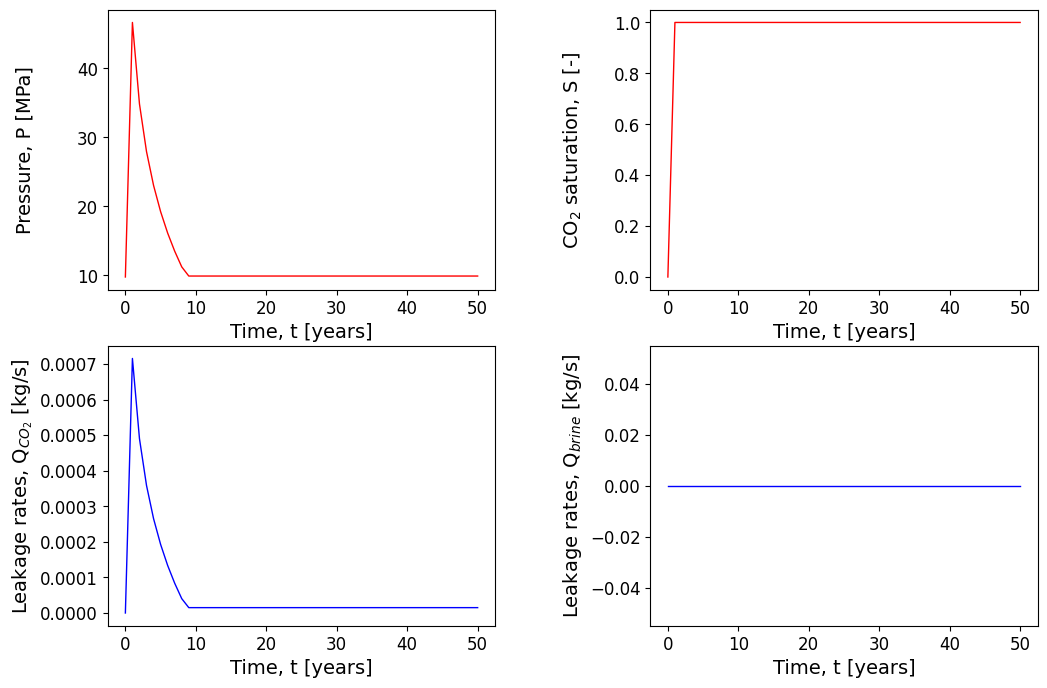

In [18]:
# Create figure
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Define figure parameters
line_width = 1
label_font_size = 14
tick_font_size = 12

# Add first subplot
axes[0, 0].plot(time_array[0:]/365.25, pressure/1.0e+6, 
               '-r', linewidth=line_width)
axes[0, 0].set_xlabel('Time, t [years]', fontsize=label_font_size)
axes[0, 0].set_ylabel(r'Pressure, P [MPa]', fontsize=label_font_size)
axes[0, 0].tick_params(labelsize=tick_font_size)

# Add second subplot
axes[0, 1].plot(time_array[0:]/365.25, CO2_saturation, 
               '-r', linewidth=line_width)
axes[0, 1].set_xlabel('Time, t [years]', fontsize=label_font_size)
axes[0, 1].set_ylabel(r'CO$_2$ saturation, S [-]', fontsize=label_font_size)
axes[0, 1].tick_params(labelsize=tick_font_size)

# Add third subplot
axes[1, 0].plot(time_array[0:]/365.25, CO2_aquifer1, 
               '-b', linewidth=line_width)
axes[1, 0].set_xlabel('Time, t [years]', fontsize=label_font_size)
axes[1, 0].set_ylabel(r'Leakage rates, Q$_{CO_2}$ [kg/s]', fontsize=label_font_size)
axes[1, 0].tick_params(labelsize=tick_font_size)

# Add fourth subplot
axes[1, 1].plot(time_array[0:]/365.25, brine_aquifer1, 
               '-b', linewidth=line_width)
axes[1, 1].set_xlabel('Time, t [years]', fontsize=label_font_size)
axes[1, 1].set_ylabel(r'Leakage rates, Q$_{brine}$ [kg/s]', fontsize=label_font_size)
axes[1, 1].tick_params(labelsize=tick_font_size)

# Align y-labels of subplots
fig.align_ylabels()

# Adjust width space between subplots
plt.subplots_adjust(wspace=0.4)